In [1]:
import os
import pandas as pd
import librosa
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

In [2]:
data = pd.read_csv('../data/orig/fold0.csv')

label_dict = pickle.load(open('../data/label_dict.pkl', 'rb'))

data.head()

,audio,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,...,rms,zcr,spectral_centroid,spectral_bandwidth,spectral_contrast,spectral_flatness,spectral_rolloff,chroma_stft,tonnetz,label
0,101415-3-0-2.wav,-402.430267,92.263443,19.303581,-13.194186,-5.806571,2.408587,-14.885646,-8.070930,-9.417303,...,0.040970,0.064127,18.768268,13.502514,16.541398,16.630498,19.648753,17.354772,46.162967,3
1,101415-3-0-3.wav,-366.390045,126.183571,31.372793,-23.601944,-12.954140,0.484963,-26.859764,-19.409349,-21.998045,...,0.041645,0.070910,20.720284,13.774403,16.284152,16.967764,22.629014,20.560066,47.529912,3
2,101415-3-0-8.wav,-421.294342,68.704620,11.104476,-1.110441,2.819345,2.400709,-8.490099,-2.868937,-2.951167,...,0.048631,0.038650,18.412426,11.427902,14.431648,14.600944,17.535107,15.939704,45.598236,3
3,102106-3-0-0.wav,-503.023651,41.203171,-17.163628,-5.996913,-3.261520,-2.782545,0.986149,-0.540494,3.539172,...,0.053906,0.011728,13.830413,13.067219,16.300568,15.081618,15.787851,18.023957,27.888315,3
4,102305-6-0-0.wav,-480.217529,83.660042,19.396654,12.069215,-4.117777,0.405425,-1.905863,3.891763,1.663885,...,0.038402,0.013637,14.168841,11.882915,13.479585,15.098517,13.733297,13.625504,34.560712,6


In [3]:
from sklearn.decomposition import PCA

feature_cols = [col for col in data.columns if col != 'audio' and col != 'label']

mfcc_cols = [f'mfcc_{i+1}' for i in range(13)]
mfcc_data = data[mfcc_cols]

X = data[feature_cols]
y = data['label']

X.head()

,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,...,mfcc_13,rms,zcr,spectral_centroid,spectral_bandwidth,spectral_contrast,spectral_flatness,spectral_rolloff,chroma_stft,tonnetz
0,-402.430267,92.263443,19.303581,-13.194186,-5.806571,2.408587,-14.885646,-8.070930,-9.417303,-6.220678,...,1.656340,0.040970,0.064127,18.768268,13.502514,16.541398,16.630498,19.648753,17.354772,46.162967
1,-366.390045,126.183571,31.372793,-23.601944,-12.954140,0.484963,-26.859764,-19.409349,-21.998045,-10.158172,...,5.320423,0.041645,0.070910,20.720284,13.774403,16.284152,16.967764,22.629014,20.560066,47.529912
2,-421.294342,68.704620,11.104476,-1.110441,2.819345,2.400709,-8.490099,-2.868937,-2.951167,-1.180557,...,-0.736803,0.048631,0.038650,18.412426,11.427902,14.431648,14.600944,17.535107,15.939704,45.598236
3,-503.023651,41.203171,-17.163628,-5.996913,-3.261520,-2.782545,0.986149,-0.540494,3.539172,1.858550,...,0.648344,0.053906,0.011728,13.830413,13.067219,16.300568,15.081618,15.787851,18.023957,27.888315
4,-480.217529,83.660042,19.396654,12.069215,-4.117777,0.405425,-1.905863,3.891763,1.663885,3.299271,...,1.517948,0.038402,0.013637,14.168841,11.882915,13.479585,15.098517,13.733297,13.625504,34.560712


In [14]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
mfcc_scaled = scaler.fit_transform(mfcc_data)

In [15]:
pca = PCA()
mfcc_pca = pca.fit_transform(mfcc_scaled)

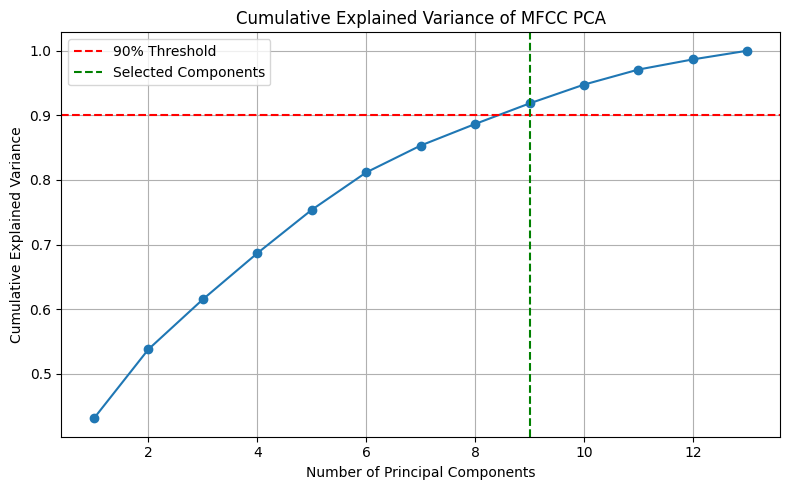

In [23]:
explained_var = pca.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_var)+1), cumulative_var, marker='o')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Cumulative Explained Variance of MFCC PCA")
plt.grid(True)
plt.axhline(y=0.9, color='r', linestyle='--', label='90% Threshold')
plt.axvline(x=np.argmax(cumulative_var >= 0.9) + 1, color='g', linestyle='--', label='Selected Components')
plt.legend()
plt.tight_layout()
plt.show()

In [33]:
def PCA_process(id, n_components=9):
    
    # 讀取資料
    data = pd.read_csv(f'../data/orig/fold{id}.csv')
    
    # 分離 MFCC 與其他特徵
    mfcc_data = data[mfcc_cols]
    other_data = data.drop(columns=mfcc_cols + ['label', 'audio'])
    y = data['label']
    
    # Step 2: 對標準化後的 MFCC 做 PCA
    pca = PCA(n_components=n_components)
    mfcc_pca = pca.fit_transform(mfcc_data)
    
    # Step 3: 保留 PCA + 其他特徵
    pca_cols = [f'pca_mfcc_{i+1}' for i in range(n_components)]
    df_pca = pd.DataFrame(mfcc_pca, columns=pca_cols)
    
    # Step 4: 合併與輸出
    final_df = pd.concat([df_pca, other_data], axis=1)
    final_df['label'] = y.values
    final_df.to_csv(f'../data/pca/fold{id}.csv', index=False)


In [34]:
for i in range(10):
	PCA_process(i)

In [35]:
fold_0 = pd.read_csv('../data/pca/fold0.csv')
fold_0.head()

,pca_mfcc_1,pca_mfcc_2,pca_mfcc_3,pca_mfcc_4,pca_mfcc_5,pca_mfcc_6,pca_mfcc_7,pca_mfcc_8,pca_mfcc_9,rms,zcr,spectral_centroid,spectral_bandwidth,spectral_contrast,spectral_flatness,spectral_rolloff,chroma_stft,tonnetz,label
0,-118.698544,-2.490409,4.647391,-41.622386,6.188609,5.942503,3.103673,-10.757173,4.933512,0.040970,0.064127,18.768268,13.502514,16.541398,16.630498,19.648753,17.354772,46.162967,3
1,-81.892405,27.531623,12.700655,-64.843290,14.117268,12.186548,5.369527,-19.767500,8.522392,0.041645,0.070910,20.720284,13.774403,16.284152,16.967764,22.629014,20.560066,47.529912,3
2,-138.009641,-24.526679,1.686268,-22.225498,2.534889,-1.779265,3.444449,-7.818999,3.267171,0.048631,0.038650,18.412426,11.427902,14.431648,14.600944,17.535107,15.939704,45.598236,3
3,-219.849773,-38.740143,-29.137182,-1.974479,-8.932227,-5.176917,-5.905142,-5.964285,1.835780,0.053906,0.011728,13.830413,13.067219,16.300568,15.081618,15.787851,18.023957,27.888315,3
4,-196.364203,-10.974930,16.777639,-15.364209,10.100963,-1.786875,-5.833701,0.065930,4.005782,0.038402,0.013637,14.168841,11.882915,13.479585,15.098517,13.733297,13.625504,34.560712,6


In [32]:
for i in range(10):
	scaler = StandardScaler()

	data = pd.read_csv(f'../data/orig/fold{i}.csv')
	X = data.drop(columns=mfcc_cols + ['label', 'audio'])
	y = data['label']

	X_scaled = scaler.fit_transform(X)

	final_df = pd.DataFrame(X_scaled, columns=X.columns)
	final_df['label'] = y.values
	final_df.to_csv(f'../data/scale/fold{i}.csv', index=False)